In [1]:
from math import sqrt, isnan

import numpy as np
import scipy.optimize
import quadpy

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
import scattnlay
from scattnlay import fieldnlay
from scattnlay import scattnlay

In [72]:
WL=455 #nm 				# wave length
core_r = 90.0			# partical radius

x = np.ones((1), dtype = np.float64)
x[0] = core_r

npts = 151					# plot will be npts x npts
factor=1.1					# area of plot

#index = 4.6265+0.13845j	# refractive index
#index = sqrt(16)
index = 4.639+0.078841j
nm = 1.0						# refractive index of host media

m = np.ones((1), dtype = np.complex128)
m[0] = index/nm

In [73]:
scan = np.linspace(-factor*x[-1], factor*x[-1], npts)
zero = np.zeros(npts*npts, dtype = np.float64)

coordX, coordZ = np.meshgrid(scan, scan)
coordX.resize(npts * npts)
coordZ.resize(npts * npts)
coordY = zero

normalize_units = np.vectorize(lambda t: 1.0*t/WL*2.0*np.pi)

coord = np.vstack((coordX, coordY, coordZ)).transpose()
_, E, _ = fieldnlay(np.array([normalize_units(x)]), np.array([m]), normalize_units(coord), pl=-1)
Ec = E[0, :, :]
#Hc = H[0, :, :]
#P = np.array(map(lambda n: np.linalg.norm(np.cross(Ec[n], Hc[n])).real, range(0, len(E[0]))))

In [74]:
from nanoscale_test import fieldplot2, rotateAroundX, rotateAroundY, rotateAroundZ, angle2D, EPS

CPU times: user 83.6 ms, sys: 60.4 ms, total: 144 ms
Wall time: 59.5 ms


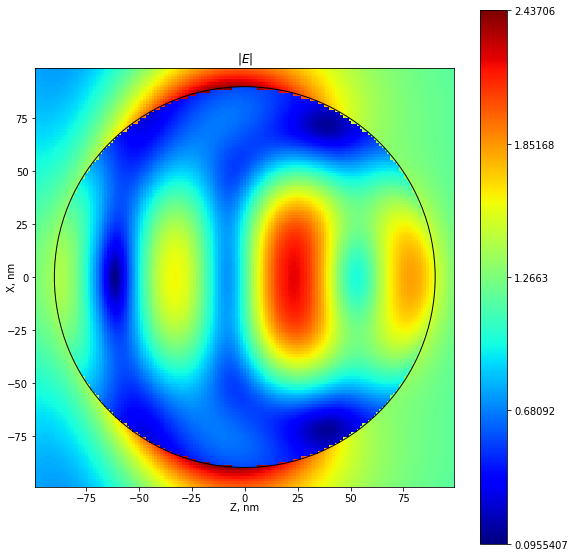

In [75]:
%%time

flow_total = 0

Er = np.absolute(Ec)
Eabs = np.sqrt(Er[:, 0]**2 + Er[:, 1]**2 + Er[:, 2]**2)
#Eabs = Er[:, 1]

fieldplot2(flow_total, Eabs, coordX, coordZ, x, m, npts, factor)

In [76]:
normalized_r = normalize_units(core_r).reshape(1)[0]
normalized_x = normalize_units(x)

In [77]:
from math import sqrt, cos, sin, acos, pi
import quadpy

In [78]:
def rotateField(vr):
    radius = np.linalg.norm(vr)
    vr = vr / radius # is not necessary
    
    #if abs(vr[0]) > EPS:
    #   pol = np.array([-vr[2] / vr[0], 0, 1])
    #elif abs(vr[2]) > EPS:
    #   pol = np.array([1, 0, -vr[0] / vr[2]])
    #else:
    #   pol = np.array([-1, 0, 0])
    b = np.array([0, 0, radius])
    #print "before", vr, "pol", pol, "b", b
    
    #if abs(vr[1]) < EPS and abs(vr[2]) < EPS:
    #    return 1.0
    
    angle = angle2D(vr[1], vr[2], 0, 1)
    vr = rotateAroundX(vr, angle)
#   pol = rotateAroundX(pol, angle)
    b = rotateAroundX(b, angle)
    #print "after1", vr, "angle", angle, "pol", pol
    
    # minus is necessary
    angle = -angle2D(vr[0], vr[2], 0, 1)
    vr = rotateAroundY(vr, angle)
#   pol = rotateAroundY(pol, angle)
    b = rotateAroundY(b, angle)
    #print "after0", vr, "angle", angle, "pol", pol

    #assert abs(pol[0]) > EPS or abs(pol[1]) > EPS
    #angle = angle2D(pol[0], pol[1], 1, 0)
    #vr = rotateAroundZ(vr, angle)
    #pol = rotateAroundZ(pol, angle)
    #b = rotateAroundZ(b, angle)
    #print "after", vr, "b", b, "pol", pol
    
    return b

def normField(b):
    _, E, H = fieldnlay(np.array([normalized_x]), np.array([m]), b.reshape(1, 3), pl=-1)
    
    assert E.shape == (1, 1, 3)
    
    vx, vy, vz = np.real(E[0][0])
    
    return sqrt(vx * vx + vy * vy + vz * vz)

def projectField(b):
    _, E, H = fieldnlay(np.array([normalized_x]), np.array([m]), b.reshape(1, 3), pl=-1)
    
    assert E.shape == (1, 1, 3)
    
    vx, vy, vz = np.real(E[0][0])
    bx, by, bz = b

    px = by * vz - bz * vy
    py = - bx * vz + bz * vx
    pz = bx * vy - by * vx
    
    return sqrt((px * px + py * py + pz * pz) / (bx * bx + by * by + bz * bz))

def directiveGain(vr):
    # TODO: divide by smth
    #return projectField(normalize_units(vr))
    
    b = rotateField(normalize_units(vr))
    return projectField(b)

CPU times: user 26 s, sys: 0 ns, total: 26 s
Wall time: 26 s


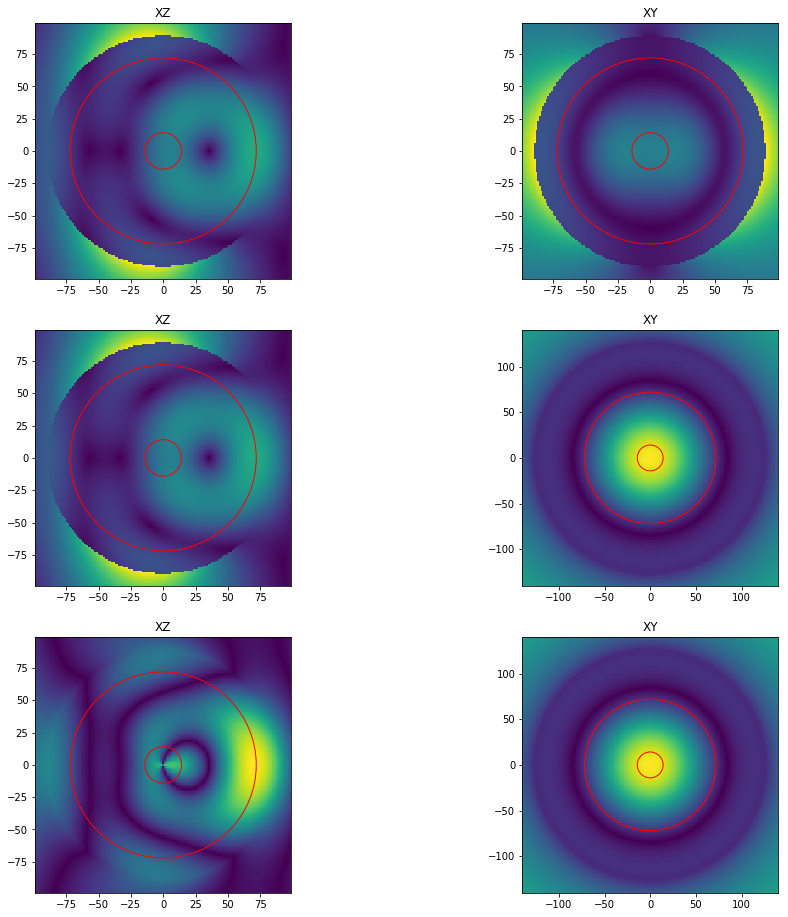

In [79]:
%%time

fig, axes = plt.subplots(3, 2, figsize=(16,16))

# draw field
coordXZ = np.vstack((coordX, zero, coordZ)).transpose()
coordXY = np.vstack((coordX, coordZ, zero)).transpose()

draw_green_image(coordXZ, fig, axes[0][0], "XZ", lambda t: normField(normalize_units(t)))
draw_green_image(coordXY, fig, axes[0][1], "XY", lambda t: normField(normalize_units(t)), True)

# draw rotated field
coordXZ = np.apply_along_axis(lambda t: rotateField(t), 1, coordXZ)
coordXY = np.apply_along_axis(lambda t: rotateField(t), 1, coordXY)

draw_green_image(coordXZ, fig, axes[1][0], "XZ", lambda t: normField(normalize_units(t)))
draw_green_image(coordXY, fig, axes[1][1], "XY", lambda t: normField(normalize_units(t)), True)

# draw projected field
draw_green_image(coordXZ, fig, axes[2][0], "XZ", lambda t: projectField(normalize_units(t)))
draw_green_image(coordXY, fig, axes[2][1], "XY", lambda t: projectField(normalize_units(t)), True)

CPU times: user 31.1 s, sys: 1.17 ms, total: 31.1 s
Wall time: 31.4 s


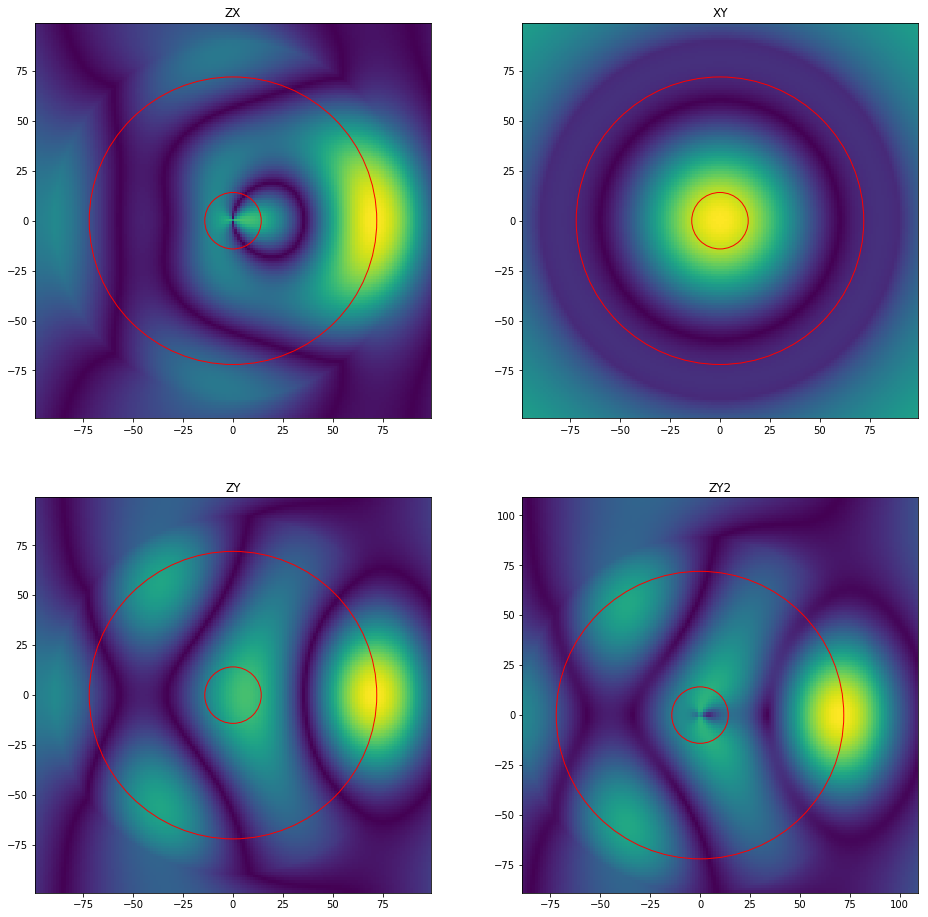

In [80]:
%%time

def draw_green_image(coord, fig, ax, title, f, rotate=False):
    min_tick = np.amin(coord)
    max_tick = np.amax(coord)

    res = np.apply_along_axis(lambda t: f(t), 1, coord)
    res = res.reshape((npts, npts))
    
    if rotate:
        res = res.transpose()

    ax.set_title(title)
    ax.imshow(res.T, origin='lower', extent=[min_tick,max_tick,min_tick,max_tick])

    ax.add_patch(Circle((0, 0), 14.14, fill=False, color='r'))
    ax.add_patch(Circle((0, 0), 72, fill=False, color='r'))
    #ax.add_patch(Circle((0, 0), 90, fill=False, color='r'))
    
fig, axes = plt.subplots(2, 2, figsize=(16,16))

coordXZ = np.vstack((coordX, zero, coordZ)).transpose()# + 1e-4
coordXY = np.vstack((coordX, coordZ, zero)).transpose()# + 1e-4
coordYZ = np.vstack((zero, coordX, coordZ)).transpose()# + 1e-4
coordYZ2 = np.vstack((zero, coordX, coordZ)).transpose() + 10

draw_green_image(coordXZ, fig, axes[0][0], "ZX", directiveGain)
draw_green_image(coordXY, fig, axes[0][1], "XY", directiveGain, True)
draw_green_image(coordYZ, fig, axes[1][0], "ZY", directiveGain)
draw_green_image(coordYZ2, fig, axes[1][1], "ZY2", directiveGain)
#_ = axes[1][1].axis('off')

In [81]:
"""
%%time
from pyevtk.hl import gridToVTK

coordX1, coordY1, coordZ1 = np.meshgrid(scan, scan, scan)
coordX1.resize(npts * npts * npts)
coordY1.resize(npts * npts * npts)
coordZ1.resize(npts * npts * npts)
coord3D = np.vstack((coordX1, coordY1, coordZ1)).transpose()
data = np.apply_along_axis(lambda t: directiveGain(t), 1, coord3D)
data = data.reshape((npts, npts, npts))

x = np.arange(data.shape[0]+1)
y = np.arange(data.shape[1]+1)
z = np.arange(data.shape[2]+1)
gridToVTK("data", x, y, z, cellData={'data':data.copy()})
"""
_ = _

In [82]:
def integrate(radius, normalized_r, normalized_x):
    return quadpy.sphere.integrate(
        lambda xs: np.apply_along_axis(lambda t: directiveGain(t * radius), 0, xs),
        [0.0, 0.0, 0.0], 1.0,
        quadpy.sphere.Lebedev("19"))

def find_max(radius):
    xs = quadpy.sphere.Lebedev("19").points
    res = np.apply_along_axis(lambda t: directiveGain(t * radius), 1, xs)
    #print "xs", xs
    #print "res", res
    return np.max(res)

In [83]:
xs = np.linspace(0.001, max(coordX), num=150)
ints = np.vectorize(lambda t: integrate(t, normalized_r, normalized_x))(xs)
maxs = np.zeros(len(xs))
for i in range(len(xs)):
    maxs[i] = find_max(xs[i])

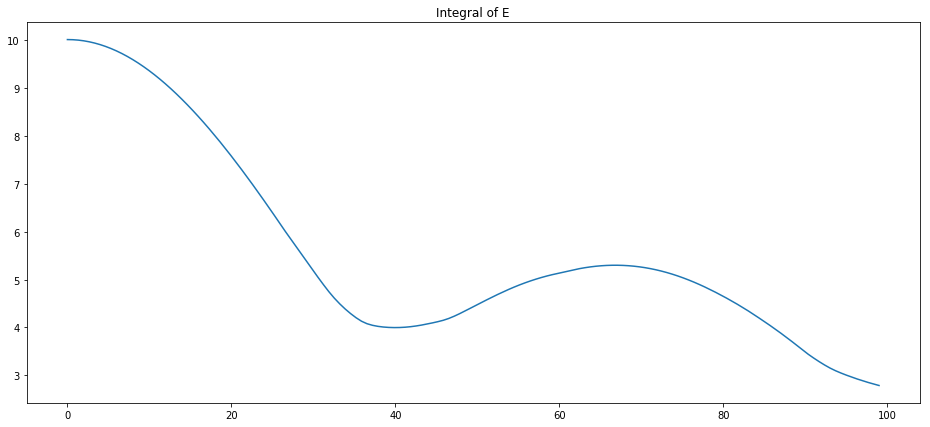

In [84]:
plt.figure(figsize=(16, 7))
plt.title("Integral of E")
_ = plt.plot(xs, ints)

Maximum is at radius 71.09424161073827


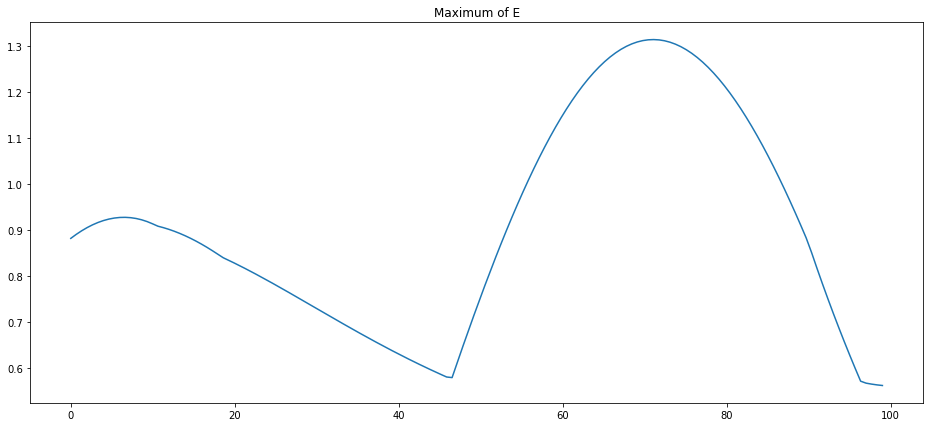

In [85]:
plt.figure(figsize=(16, 7))
plt.title("Maximum of E")
_ = plt.plot(xs, maxs)
maxrad = xs[np.argmax(maxs)]
print "Maximum is at radius", maxrad
#_ = plt.axvline(x=maxrad)

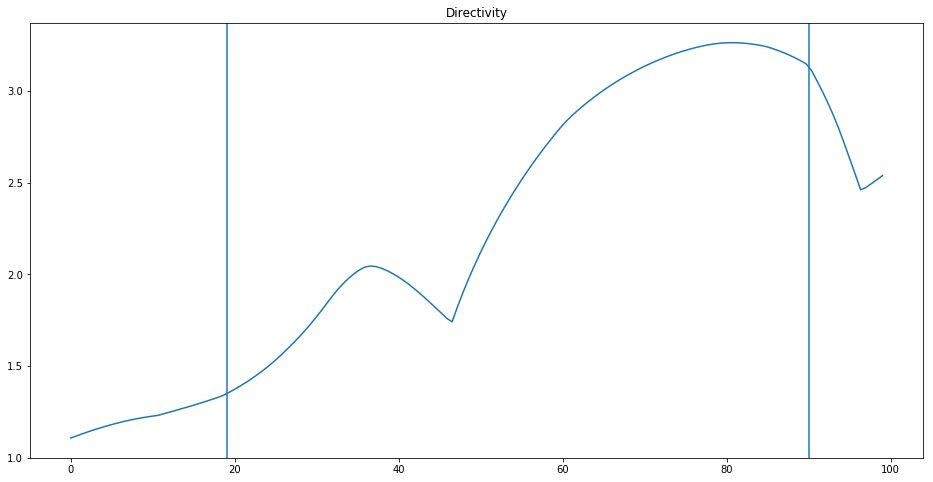

In [86]:
plt.figure(figsize=(16,8))
plt.title("Directivity")
_ = plt.plot(xs, maxs / ints * 4 * pi)
_ = plt.axvline(x=90)
_ = plt.axvline(x=19)